# Import Detectron2 with Custom COCO Datasets

In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import gdown
import torch
import math
import random

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_instances

from glob import glob
import xml.etree.ElementTree as ET

## Register your own data set in coco format configs

In [2]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("wamv_train",)
cfg.DATASETS.TEST = ("wamv_val", )
cfg.DATALOADER.NUM_WORKERS = 0 #Single thread
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # datasets classes
cfg.SOLVER.IMS_PER_BATCH = 4 #Batch size
ITERS_IN_ONE_EPOCH = 610 #dataset_imgs/batch_size
cfg.SOLVER.MAX_ITER = (ITERS_IN_ONE_EPOCH * 50) # ITERS
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MOMENTUM = 0.9
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.GAMMA = 0.1
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.SOLVER.WARMUP_FACTOR = 1.0 / 1000
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.WARMUP_METHOD = "linear"
cfg.SOLVER.CHECKPOINT_PERIOD = ITERS_IN_ONE_EPOCH #Save training model interval
cfg.MODEL.WEIGHTS = "wamv_boats_bigboats_sailboats/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
register_coco_instances('wamv_val', {}, 
                        '/home/arg/Mask-RCNN-Detectron2/datasets/wamv_boats_split/val.json', 
                       '/home/arg/Mask-RCNN-Detectron2/datasets/wamv_boats_split/val')
cfg.DATASETS.TEST = ("wamv_val", )
subt_metadata = MetadataCatalog.get("wamv_val")
dataset_dicts = DatasetCatalog.get("wamv_val")
#print(dataset_dicts)


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



## Visualize dataset - make sure the data is loaded without problems

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the dataset.

In [3]:
def create_label_image(image_path):
    image = cv2.imread(image_path)
    xml_path = image_path.replace('.jpg', '.xml')
    
    # parse xml file
    tree = ET.parse(xml_path)
    root = tree.getroot() # get root object
    
    # get bbox labels and draw on image
    for member in root.findall('object'):
        class_name = member[0].text # class name

        # bbox coordinates
        xmin = int(member[4][0].text)
        ymin = int(member[4][1].text)
        xmax = int(member[4][2].text)
        ymax = int(member[4][3].text)
        
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 5)
        cv2.putText(image, class_name, (xmin, ymin), cv2.FONT_HERSHEY_TRIPLEX, 1, (0, 255, 255), 3, cv2.LINE_AA)
    
    return image

Total dataset: 10 images


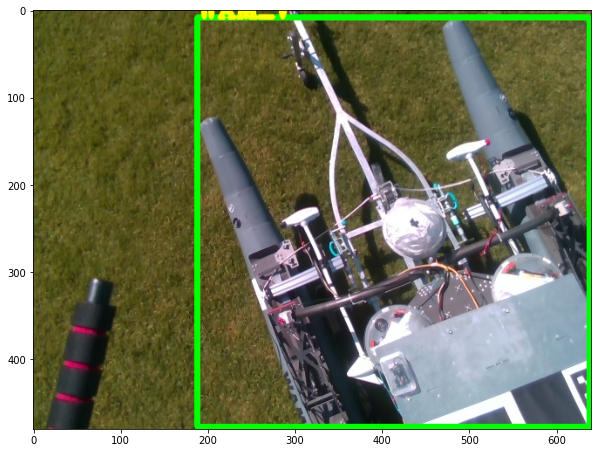

In [4]:
data_path = '/home/arg/Mask-RCNN-Detectron2/datasets/wamv_real_view'

images = sorted(glob(data_path + '/*.jpg'))

print("Total dataset: %s images" % len(images))

for img_path in random.sample(images, 1):
    label_image = create_label_image(img_path)
    show_img = cv2.cvtColor(label_image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(show_img)
    plt.show()

## Make a prediction

In [5]:
models_name = "model_final.pth"
if os.path.isfile("wamv_boats_split/" + models_name):
    print("Finished downloading models.") 

Finished downloading models.


Total dataset: 10 images


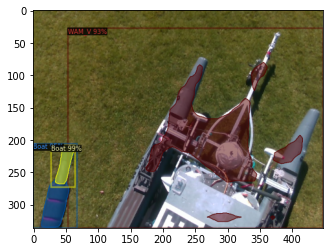

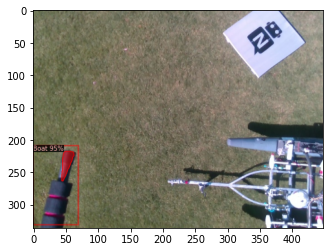

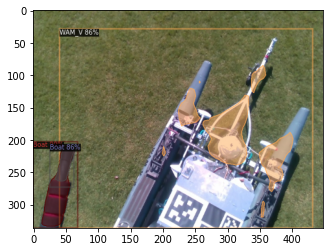

pred_classes contains integers larger than 3


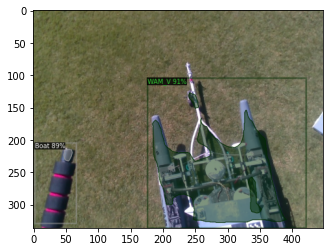

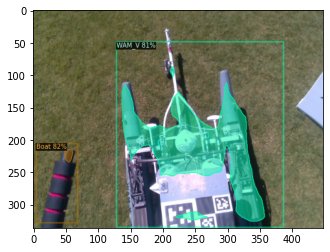

pred_classes contains integers larger than 3


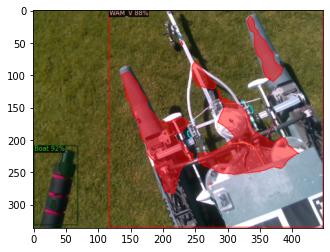

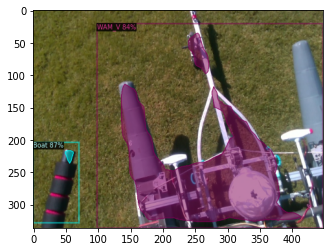

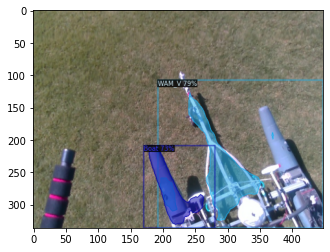

In [6]:
from detectron2.utils.visualizer import ColorMode
import random

predictor = DefaultPredictor(cfg)

data_path = '/home/arg/Mask-RCNN-Detectron2/datasets/wamv_real_view'
images = sorted(glob(data_path + '/*.jpg'))

print("Total dataset: %s images" % len(images))

for img_path in images:
    im = cv2.imread(img_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    #print(im)
    outputs = predictor(im)
    #print(outputs)
    v = Visualizer(im[:, :, ::-1],
                   metadata=subt_metadata, 
                   scale=0.7
    )
    pred_classes = outputs["instances"].pred_classes
    if (pred_classes > 2).any():
        print("pred_classes contains integers larger than 3")
    else:
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        plt.imshow(v.get_image()[:, :, ::-1], cmap='nipy_spectral')
        plt.show()

## Inference

In [7]:
def iou(box1, box2):
    # Calculate the intersection area
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    # Calculate the union area
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    union_area = box1_area + box2_area - intersection_area
    # Calculate the IoU
    iou = intersection_area / union_area
    return iou

In [10]:
def inference(data_dir, label_map, min_score_thresh=0.7, iou_thres=0.5, line_thickness=4):
    test_imgs_path = sorted(glob(data_dir + '/*.jpg'))
    
    #otal_label = {'WAM_V':0, 'Boat':0}
    #total_predict = {'WAM_V':0, 'Boat':0}
    #total_TP = {'WAM_V':0, 'Boat':0}
    total_label = {'WAM_V':0}
    total_predict = {'WAM_V':0}
    total_TP = {'WAM_V':0}
    
    predictor = DefaultPredictor(cfg)
    
    sample_num = 10
    for test_img_path in random.sample(test_imgs_path, sample_num):
    # for test_img_path in test_imgs_path:
        test_xml_path = test_img_path.replace('.jpg', '.xml')
        #print(f"xml_path='{test_xml_path}'")
        test_img = cv2.imread(test_img_path)
        test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
        input_img = [cv2.resize(test_img, (780, 780))]
        # parse xml file
        tree = ET.parse(test_xml_path)
        root = tree.getroot() # get root object
        gt_boxes = []
        #add groundtruth bounding box
        for member in root.findall('object'):
            class_name = member[0].text # class name
            total_label[class_name] += 1
            # bbox coordinates
            xmin = int(member[4][0].text)
            ymin = int(member[4][1].text)
            xmax = int(member[4][2].text)
            ymax = int(member[4][3].text)
            # resize bounding box
            xmin = int(xmin * (780 / test_img.shape[1]))
            ymin = int(ymin * (780 / test_img.shape[0]))
            xmax = int(xmax * (780 / test_img.shape[1]))
            ymax = int(ymax * (780 / test_img.shape[0]))
            #print((xmin, ymin), (xmax, ymax))
            gt_boxes.append([class_name, (xmin, ymin, xmax, ymax)])
                
        # Inference
        #detections_bs = self.driver.serve_images(input_img)
        outputs = predictor(test_img)
        v = Visualizer(im[:, :, ::-1],
                   metadata=subt_metadata, 
                   scale=0.7
        )
        pred_classes = outputs["instances"].pred_classes
        for pred_class in pred_classes:
            pred_class -= 1
            #if (pred_class > 2):
            if (pred_class > 1):
                print("pred_classes contains integers larger than 3")
            elif (pred_class == 0):
                total_predict['WAM_V']  += 1
                total_TP['WAM_V']  += 1
            #elif (pred_class == 1):
            #   total_predict['Boat']  += 1
        continue
        for detection in detections_bs[0]:
            #print(detection)
            if detection[5] > min_score_thresh:
                total_predict[label_classes[detection[6]]] += 1
                xmin = detection[2]
                ymin = detection[1]
                xmax = detection[4]
                ymax = detection[3]
                #cv2.rectangle(combine_image, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)     
                for gt_box in gt_boxes:
                    iou_value = iou((xmin, ymin, xmax, ymax), gt_box[1])                    
                    if iou_value > iou_thres:
                        if label_classes[detection[6]] == gt_box[0]:
                              #print(gt_box[0] + " : ")
                              #print(iou_value)
                              total_TP[gt_box[0]] += 1      
    print("After sampling " + str(sample_num) + " images in dataset, the result is below")
    print("label :")
    print(total_label)
    print("predict :")
    print(total_predict)
    print("TP :")
    print(total_TP)
    total_FP = {k: total_predict[k] - total_TP.get(k, 0) for k in total_predict}
    print("FP :")
    print(total_FP)
    total_FN = {k: total_label[k] - total_TP.get(k, 0) for k in total_label}
    print("FN :")
    print(total_FN)
    total_percision = {k: total_TP[k] / total_predict.get(k, 0) for k in total_TP}
    print("percision :")
    print(total_percision)
    total_recall = {k: total_TP[k] / total_label.get(k, 0) for k in total_TP}
    print("recall :")
    print(total_recall)

In [11]:
data_dir = '/home/arg/Mask-RCNN-Detectron2/datasets/wamv_real_view'
label_map = {1: 'WAM_V',2: 'Boat'}
threshold = 0.5
iou_thres = 0.3

inference(data_dir, label_map, threshold, iou_thres)

pred_classes contains integers larger than 3
pred_classes contains integers larger than 3
After sampling 10 images in dataset, the result is below
label :
{'WAM_V': 10}
predict :
{'WAM_V': 7}
TP :
{'WAM_V': 7}
FP :
{'WAM_V': 0}
FN :
{'WAM_V': 3}
percision :
{'WAM_V': 1.0}
recall :
{'WAM_V': 0.7}
